In [1]:
import utils.stan_utility as stan_utility
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import seaborn as sns
import pandas as pd

import scipy.stats as stats

In [3]:
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [43]:
airline_data = pd.read_csv('data.csv', header=0)
print(airline_data)

   Year  Fatal accidents  Passenger deaths  Death rate  \
0  1976               24               734        0.19   
1  1977               25               516        0.12   
2  1978               31               754        0.15   
3  1979               31               877        0.16   
4  1980               22               814        0.14   
5  1981               21               362        0.06   
6  1982               26               764        0.13   
7  1983               20               809        0.13   
8  1984               16               223        0.03   
9  1985               22              1066        0.15   

   Miles flown [100 mln miles]  
0                       3863.0  
1                       4300.0  
2                       5027.0  
3                       5481.0  
4                       5814.0  
5                       6033.0  
6                       5877.0  
7                       6223.0  
8                       7433.0  
9                       7107.0 

### Prior for death rate
We assume that having dearh rate equals 100% would be very improbable. For poisson distribution we have mean of $\lambda$ and standard deviation of $\sqrt{\lambda}$. Approximately in order to have no more than 1% probability $\lambda$ should fulfill

$$\lambda+3\sqrt{\lambda}\approx100 \%$$
We need to assign the prior that would have probability of smaller $\lambda$ equal 99%.

In [25]:
root_of_lam=np.polynomial.polynomial.polyroots([-100.,3.,1.])
lam_ub=np.round(root_of_lam[root_of_lam>0]**2)
print(lam_ub)

[74.]


In [22]:
with open('stan_model/prior_tuning.stan', 'r') as file:
    print(file.read())

functions {
  // Difference between one-sided Gaussian tail probability and target probability
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess; // Initial guess of Gaussian standard deviation
  vector[1] theta;       // Target quantile
}

transformed data {

  vector[1] y;
  real x_r[0];
  int x_i[0];

  // Find Gaussian standard deviation that ensures 99% probabilty below 15
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);

  print("Standard deviation = ", exp(y[1]));
}

generated quantities {
  real sigma = exp(y[1]);
}





In [12]:
tuning = stan_utility.compile_model('stan_model/prior_tuning.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5906b94fc4474bc4a912dc8dd0f23b98 NOW.


In [26]:
data=dict(y_guess=np.array([np.log(100)]),theta=np.array(lam_ub))
tuned = tuning.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = np.round(tuned.extract()['sigma'][0])
print(sigma)

29.0


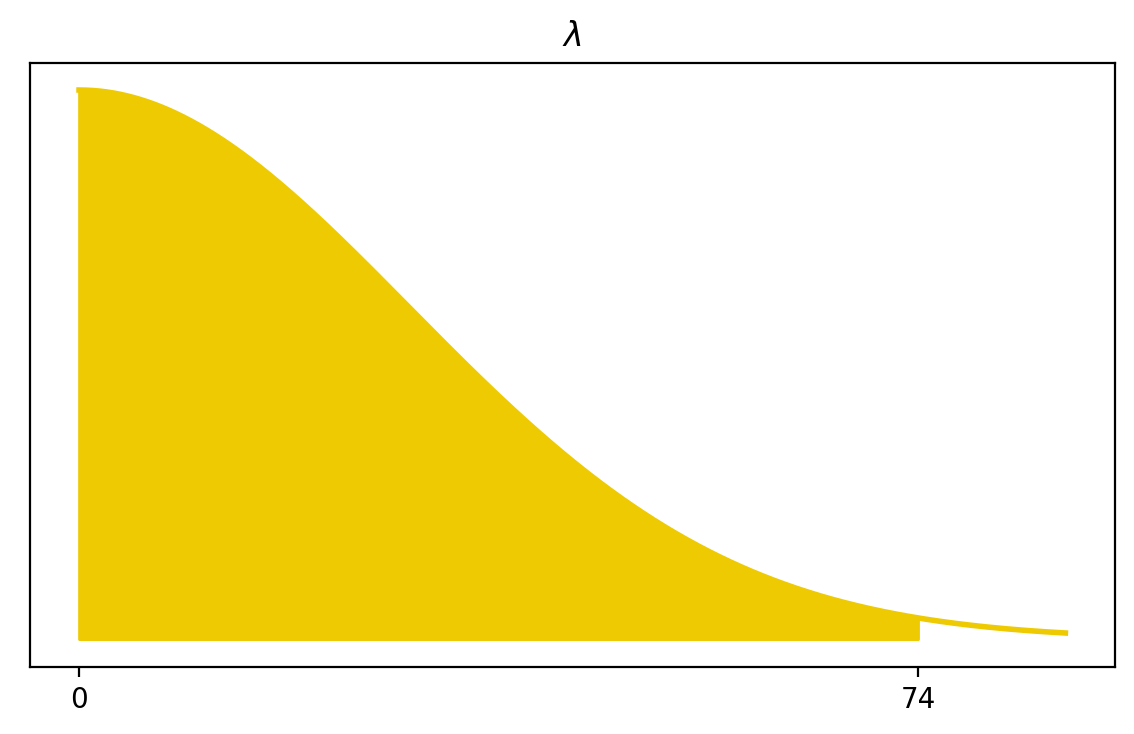

In [27]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lam_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

### Prior predictive distribution
We can use stan to simulate possible outputs and parameteres based only on prior information.

In [32]:
with open('stan_model/airline_deathrate_hn_ppc.stan', 'r') as file:
    print(file.read())

data {
  int sigma; //poisson lambda argument
}


generated quantities {
  real lambda = fabs(normal_rng(0, sigma));
  int y_sim = poisson_rng(lambda);
}





In [33]:
model_prior=stan_utility.compile_model('stan_model/airline_deathrate_hn_ppc.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0c9680487c8b109878978cdbc13457e8 NOW.


In [36]:
R = 1000
sim_uf = model_prior.sampling(data={'sigma': int(sigma)},
                            algorithm="Fixed_param",
                            iter=R,
                            warmup=0,
                            chains=1, 
                            refresh=R,
                            seed=29042020)

In [64]:
## generation of vector for plotting samples under histograms
dr=[]
dr_cnt=[]
for k in airline_data['Death rate']:  
    k*=100
    dr_cnt.append(-(1.+dr.count(k)))
    dr.append(k)
dr_cnt=np.array(dr_cnt)

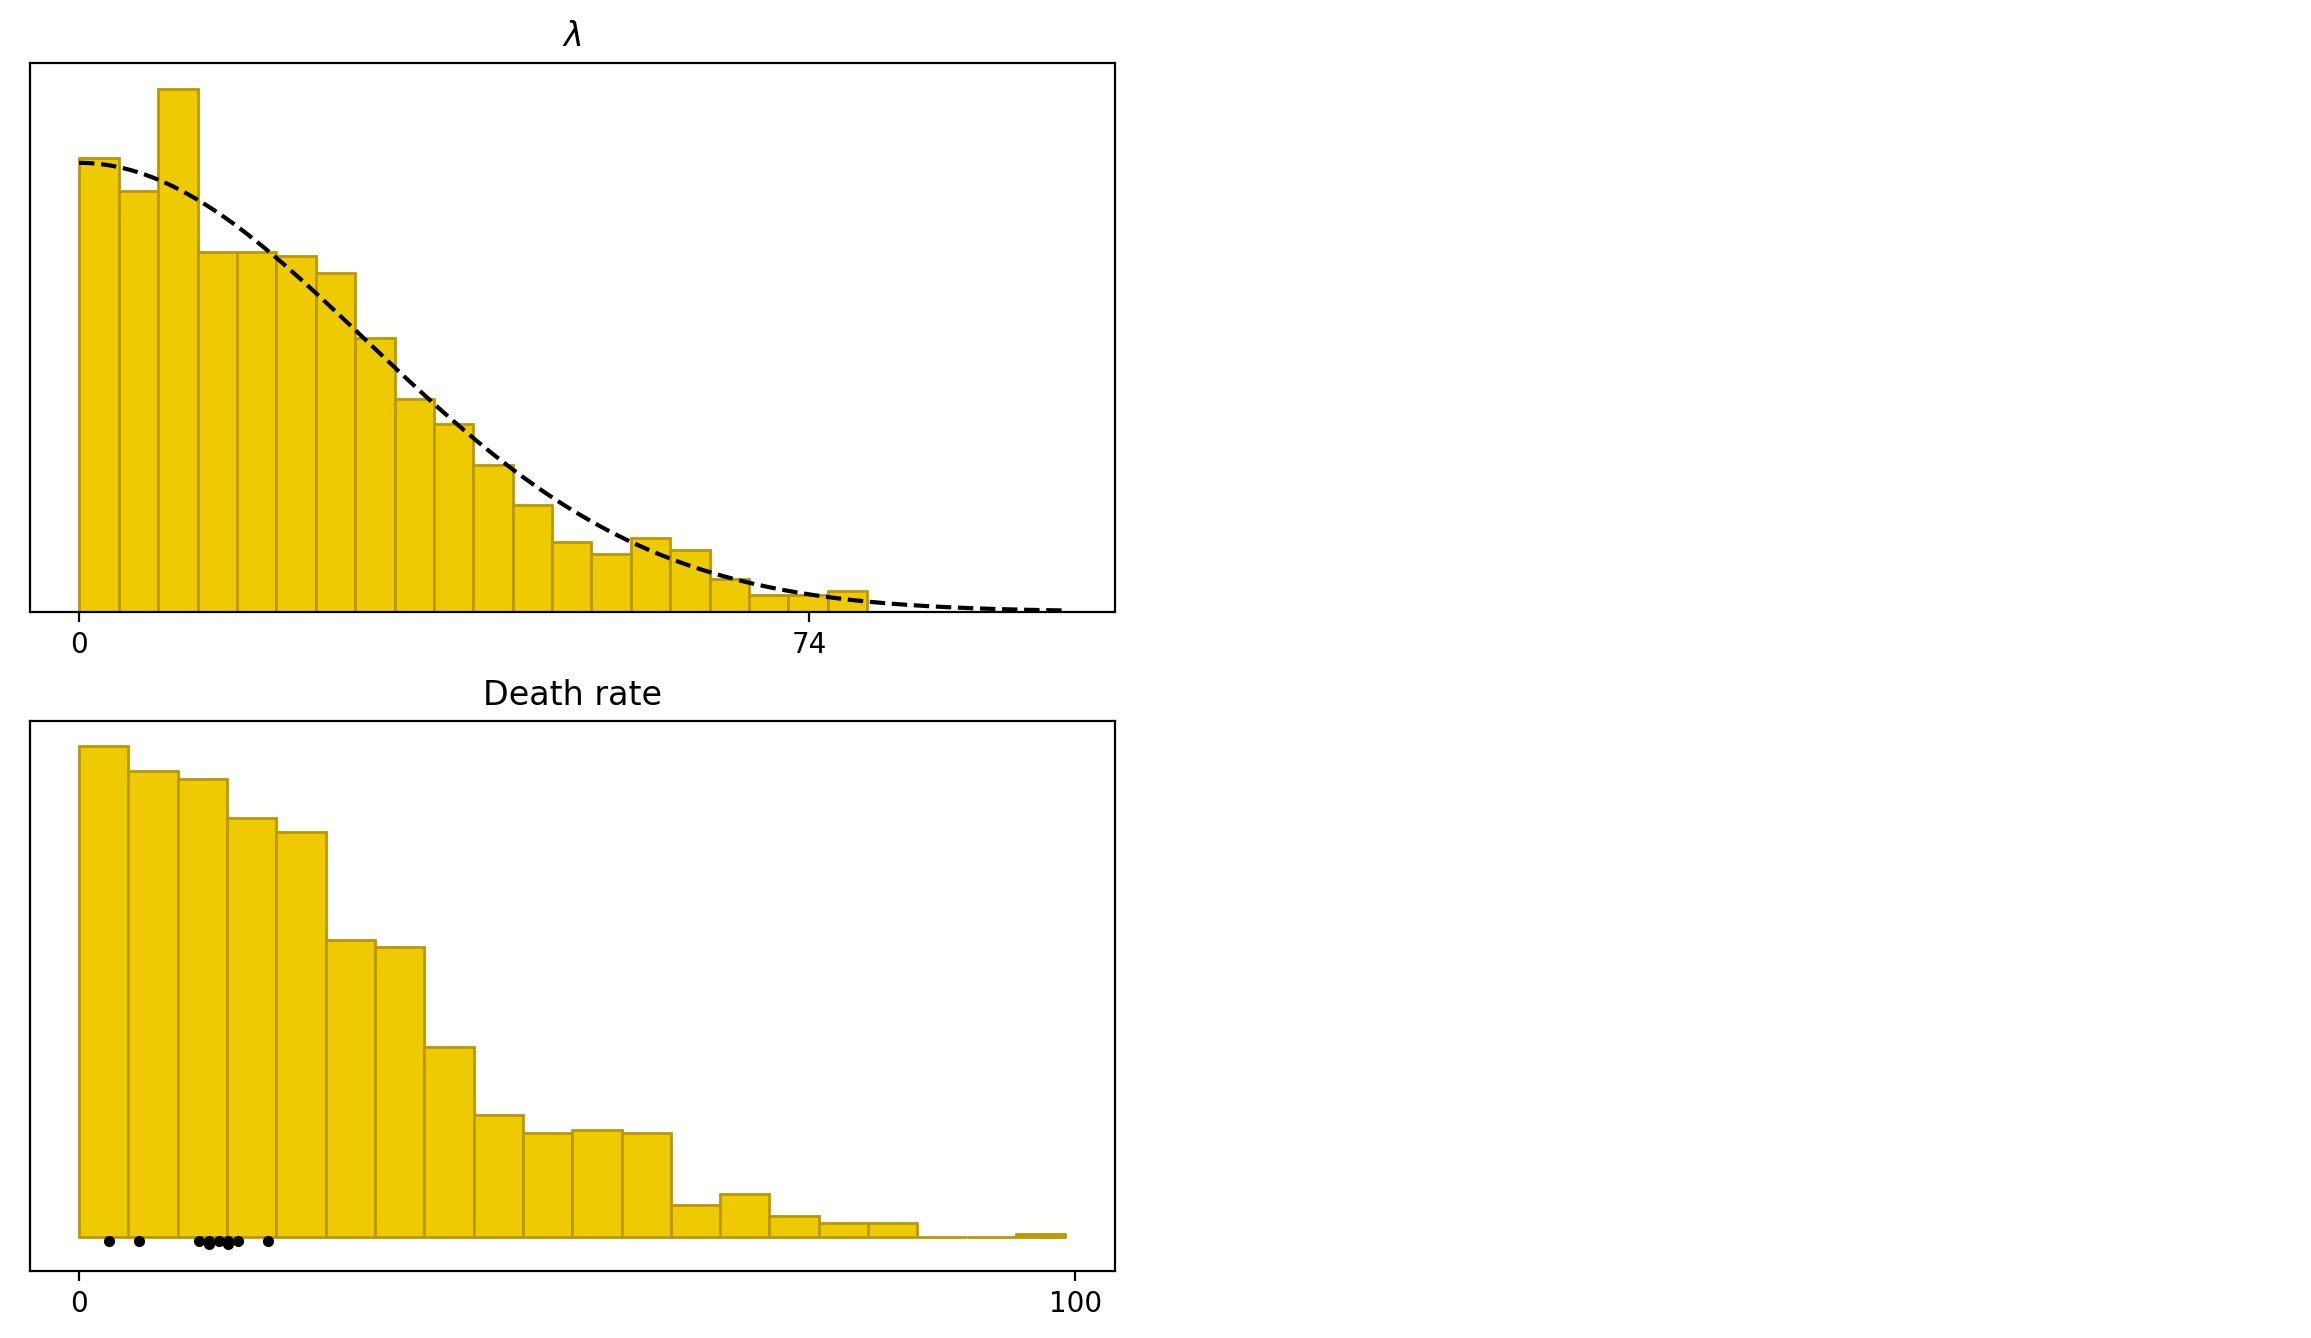

In [65]:
params = sim_uf.extract()
lambda0 = params['lambda']
y_sim = params['y_sim']

fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(lambda0, bins=20, color=dark, edgecolor=dark_highlight, density=True)
x=np.linspace(0, 100, 2000)
ax1.set_xticks([0, lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(150,0,sigma)
ax1.annotate('HalfNormal(0,'+str(np.int(sigma))+')',xy=(150,arr_y_loc),xytext=(200,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax2=axes[1]
ax2.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax2.scatter(dr, 0.0002*dr_cnt, color='black', marker='.', zorder=2)
ax2.set_xticks([0, 100])
ax2.set_yticks([])

ax2.set_title('Death rate')
plt.show()